# Mask R-CNN - Inspect Trained Model

Inspect the detection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g4juQprmWNleKuKudWCeDfC4Q0qwomKcP9yovUBVn69DjKTL1Ixk2w


ValueError: ignored

In [ ]:
%cd /content/gdrive/My Drive/MRCNN/

/content/gdrive/My Drive/MRCNN


In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR + "/mrcnn")  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
sys.path.append(ROOT_DIR + "/urinestick") 
import urinestick as stick

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/content/gdrive/My Drive/MRCNN
/content/gdrive/My Drive/MRCNN


## Configurations

In [ ]:
config = stick.StickConfig()
STICK_DIR = os.path.join(ROOT_DIR, "dataset")
print(STICK_DIR)

/content/gdrive/My Drive/MRCNN/dataset


In [ ]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Notebook Preferences

In [ ]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [ ]:
# Load testing dataset

dataset = stick.StickDataset()
dataset.load_stick(STICK_DIR, "test")


Working with test set, Fold 3


## Load Model

In [ ]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
# Set path to weights file
# weights_path = MODEL_DIR + "/Run1/mask_rcnn_stick_0015.h5"
weights_path = MODEL_DIR + "/Fold_3/mask_rcnn_stick_0015.h5"

# Or, load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/gdrive/My Drive/MRCNN/logs/Fold_3/mask_rcnn_stick_0015.h5


## Function to crop found stick

In [ ]:
def crop_rect(img, rect):
    """
    Function, that crops a rectangle from an image

    Input:
      img: Whole image
      rect: Parameters of the rectangle that will be cut out: in the form center

    Output:
      detectedStick
    """

    # Shape of the Image
    height, width = img.shape[0], img.shape[1]

    # Create border, to prevent cutting off image parts during rotation
    # T = np.float32([[1, 0, width/2], [0, 1, height/2]])
    # img_mod = cv2.warpAffine(img, T, (width*2, height*2))

    # Parameters of the rectangle
    center = rect[0]
    size = rect[1]
    angle = rect[2]

    center, size = tuple(map(int, center)), tuple(map(int, size))

    M = cv2.getRotationMatrix2D(center, angle, 1)
    img_rot = cv2.warpAffine(img, M, (width, height))
    img_crop = cv2.getRectSubPix(img_rot, size, center)
    
    return img_crop

## Run Detection on test set

In [ ]:
import json
import imutils
import skimage.draw
import cv2
import numpy as np
import pickle

DIR_RESULTS = "/content/gdrive/MyDrive/MRCNN/results_run_2.pckl"
JSON_DIR = "/content/gdrive/MyDrive/MRCNN/dataset/00_test_k2.json"
DIR = "/content/gdrive/MyDrive/MRCNN/dataset/"

In [ ]:
# Load ground truth annotations
annotations = json.load(open((JSON_DIR)))
print(len(annotations))

results = []
images = []
annotations_filtered =[]
f = open(DIR_RESULTS, 'ab')
for annot in annotations:

  image_dir = DIR+annot["filename"]
  print(image_dir)
  # Read image
  if not os.path.isfile(image_dir) or not annot["regions"]:
    continue
  image = skimage.io.imread(image_dir)

  # Run object detection
  result = model.detect([image], verbose=0)
  results.append(result)

  pickle.dump([result,image,annot], f)
  

f.close()

# **Open calculated results**

In [ ]:
f = open(DIR_RESULTS, 'rb')
result,image,annot = pickle.load(f)
print("results successfully loaded")


results successfully loaded


# **Intersection over Union (IoU) or Jaccard Index**



In [ ]:
import json
import imutils
import skimage.draw
import cv2
import numpy as np
import pickle

print(" PPV; \tNPV; \tFilename")

i = 0;
f = open(DIR_RESULTS, 'rb')
cntPos = 0
cntNeg = 0
sumPPV = 0
sumNPV = 0
sumJac = 0
sumDice = 0
APs = []
while 1:
  
  try:
    result,image,annot = pickle.load(f)
  except EOFError:
    print("DONE")
    break 

  height, width, _ = image.shape
  mask_ref = np.zeros([height, width], dtype=np.uint8)
  for n in range(len(annot["regions"])):
    p = annot["regions"][str(n)]["shape_attributes"]
    rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
    mask_ref[rr, cc] = 1

  
  r = result[0]
  mask_sub = r['masks']
  mask_sub = mask_sub.astype(np.uint8)

  #print(mask_sub)
  if (mask_sub.size == 0):
    print("00.00%;\t 00.00%;\t 00.00%;\t 00.00%;\t {}".format(annot["filename"]))
    cntNeg += 1
    continue
  mask_sub = mask_sub[:,:,0]
 
  #Compare both masks
  super_mask = mask_sub + mask_ref
  neg_mask = mask_sub.astype(np.int8) - mask_ref.astype(np.int8)
  true_positive = sum(sum(map(lambda x : x == 2, super_mask)))
  true_negative = sum(sum(map(lambda x : x == 0, super_mask)))
  false_positive = sum(sum(map(lambda x : x == 1, neg_mask)))
  false_negative = sum(sum(map(lambda x : x == -1, neg_mask)))

  
  PPV = true_positive/(true_positive + false_positive)  #Positive predictive value or intersection over union
  NPV = true_negative/(true_negative+false_negative)       #Negative predictive value    
  jaccard = true_positive/(true_positive + false_positive + false_negative)
  dice = 2*true_positive/(2*true_positive + false_positive + false_negative)
  print("{:0.2%};\t {:0.2%};\t {:0.2%};\t {:0.2%};\t {}".format(PPV,NPV,jaccard, dice, annot["filename"]))
  sumPPV += PPV
  sumJac += jaccard
  sumDice += dice
  
  i += 1

  
# Dice Coefficient / F1-Score


print(i)
print("Anzahl Positiv;\t Anzahl Negativ;\t Mean IoU;\t Mean Dice ")    
print("{}  ;{};  {:0.4%}  ;{:0.4%}".format(cntPos, cntNeg, sumJac/115, sumDice/115))


 PPV; 	NPV; 	Filename
93.95%;	 99.76%;	 84.96%;	 91.87%;	 1604650773203-image.jpg
99.80%;	 99.70%;	 87.58%;	 93.38%;	 1604650911731-image.jpg
00.00%;	 00.00%;	 00.00%;	 00.00%;	 1604572813636-IMG_0038.jpg
100.00%;	 98.55%;	 57.01%;	 72.62%;	 1604347536258-2020-11-0221.04.527950054788212704818.jpg
99.86%;	 97.64%;	 35.37%;	 52.25%;	 1604347691476-2020-11-0221.07.584019032657385811007.jpg
99.87%;	 99.17%;	 79.33%;	 88.48%;	 1604347893130-2020-11-0221.11.076903911206488238889.jpg
98.33%;	 99.38%;	 73.87%;	 84.97%;	 1604348016461-2020-11-0221.13.194761313437091000228.jpg
99.10%;	 99.87%;	 92.61%;	 96.16%;	 1605368808626-16053687969671489409661.jpg
91.38%;	 99.92%;	 87.48%;	 93.32%;	 1605368883340-16053688596131861194117.jpg
87.48%;	 99.85%;	 81.15%;	 89.59%;	 1605368909089-1605368898417-13225481.jpg
98.51%;	 99.80%;	 89.72%;	 94.58%;	 1605368963241-1605368953900-1538427202.jpg
96.00%;	 99.76%;	 86.53%;	 92.78%;	 1605369055926-1605369042130-18521828.jpg
96.95%;	 99.81%;	 86.73%;	 92.90%;	 1

In [ ]:
import json
import imutils
import skimage.draw
import cv2
import numpy as np
import os
import pickle
import sys
# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR + "/mrcnn")  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

cnt_pos = 0
cnt_neg = 0
i = 0;
f = open(DIR_RESULTS, 'rb')
len_faktor_h = 1.5;
len_faktor_w = 1.5;
while 1:
  
  try:
    result,image,annot = pickle.load(f)
  except EOFError:
    print("DONE")
    break 
  r = result[0]
  mask_sub = r['masks']
  mask_sub = mask_sub.astype(np.uint8)

  if (mask_sub.size == 0):
    cnt_neg += 1
    print("------  ;------- ;       {}".format(annot["filename"]))
    continue
  mask_sub = mask_sub[:, :, 0]
  cnt, hierarchy = cv2.findContours(
      mask_sub, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  if not cnt:
      cnt_neg+=1
      continue
      print("------  ;------- ;       {}".format(annot["filename"]))
  
  img_h, img_w, _ = image.shape
  T = np.float32([[1, 0, img_w/2], [0, 1, img_h/2]])
  img_mod = cv2.warpAffine(image, T, (img_w*2, img_h*2))

  rectangle = cv2.minAreaRect(cnt[0])
  #print("Vorher: " , rectangle)
  rectangle = ((rectangle[0][0]+img_w/2, rectangle[0][1]+img_h/2), (rectangle[1][0]*len_faktor_w, rectangle[1][1]*len_faktor_h),(rectangle[2]))
  # rectangle = ((rectangle[0][0], rectangle[0][1]), (rectangle[1][0]*len_faktor_w, rectangle[1][1]*len_faktor_h),(rectangle[2]))
  #print("Nachher: " , rectangle)
  corners = cv2.boxPoints(rectangle)
  corners = np.int0(corners) 
  #image = cv2.imread(image_dir+filename)
  height, width, _ = img_mod.shape
  mask_ref = np.zeros([height, width], dtype=np.uint8)
  rr, cc = skimage.draw.polygon(corners[:, 1], corners[:, 0])


  # detected_stick = crop_rect(img_mod, rectangle)
  # display_images([detected_stick],cols = 1)
  try:
    mask_ref[rr, cc] = 1
  except:
    cnt_neg += 1
    continue

  for n in range(len(annot["regions"])):
        num_matches = 0
        for i in range(len(annot["regions"][str(n)]["shape_attributes"]["all_points_x"])):
            x_point = annot["regions"][str(
                n)]["shape_attributes"]["all_points_x"][i]
            x_point += img_w/2
            y_point = annot["regions"][str(
                n)]["shape_attributes"]["all_points_y"][i]
            y_point += img_h/2

            if mask_ref[int(y_point), int(x_point)] == 1:
                num_matches += 1

        if num_matches == len(annot["regions"][str(n)]["shape_attributes"]["all_points_x"]):
            cnt_pos += 1
            break
  else:
          cnt_neg += 1
print("Nums positiv, negativ: ", cnt_pos, cnt_neg)
# print("finished. All files: ", len(corner_dict))

------  ;------- ;       1606753864608-16067538558916752232523575521314.jpg
------  ;------- ;       1605347358846-image.jpg
------  ;------- ;       20201125_170928.jpg
------  ;------- ;       20201125_170934.jpg
------  ;------- ;       20201125_171050.jpg
DONE
Nums positiv, negativ:  100 17


## Color Splash

This is for illustration. Call `urinestick.py` with the `splash` option to get better images without the black padding.

In [ ]:
ex_img = skimage.io.imread("./dataset/IMG_20201214_221109_HDR.jpg")
splash = stick.color_splash(ex_image, r['masks'])
display_images([splash], cols=1)

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [ ]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:  -18.09199  max:    7.79745  float64
positive_anchors         shape: (4, 4)                min:  466.74517  max:  922.50967  float64
negative_anchors         shape: (252, 4)              min:  -45.25483  max: 1025.65685  float64
neutral anchors          shape: (261632, 4)           min:  -90.50967  max: 1050.50967  float64
refined_anchors          shape: (4, 4)                min:   74.00015  max:  935.00000  float32


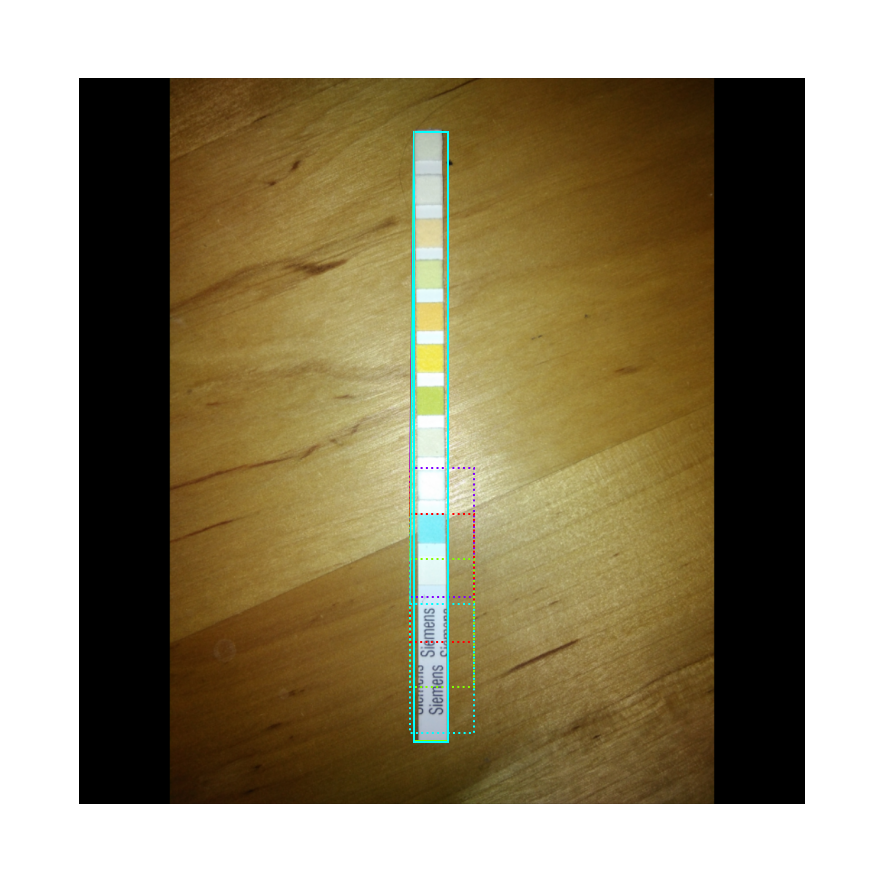

In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35390  max:    1.29134  float32
refined_anchors          shape: (1, 6000, 4)          min:   -1.29250  max:    1.95527  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 3278.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


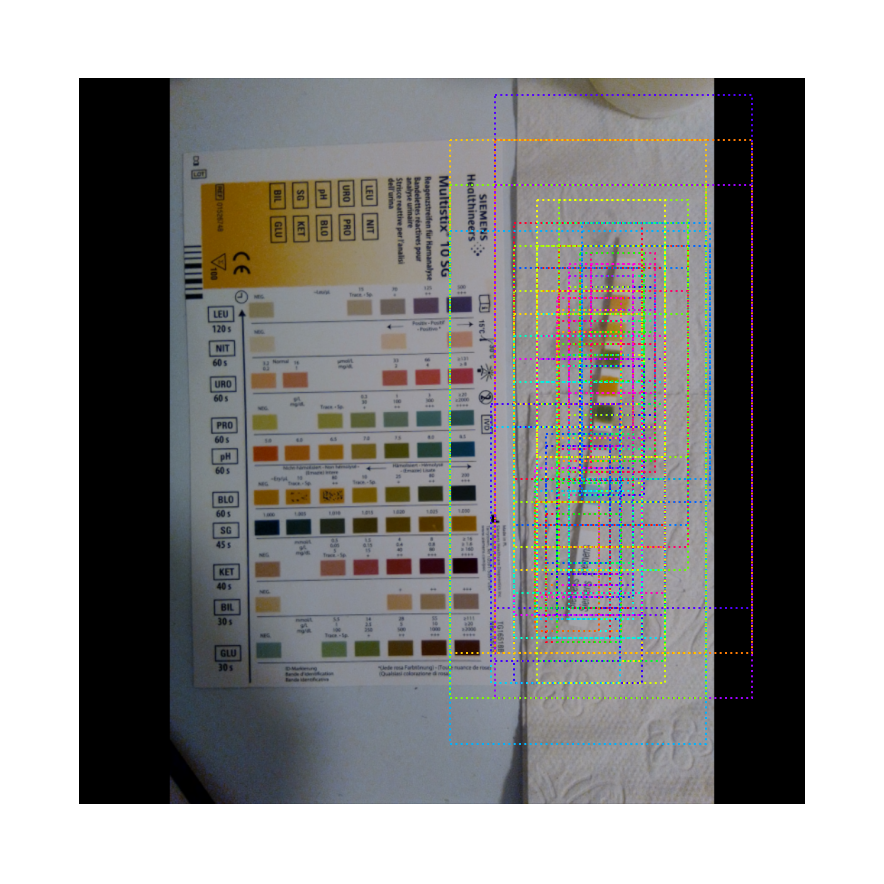

In [ ]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

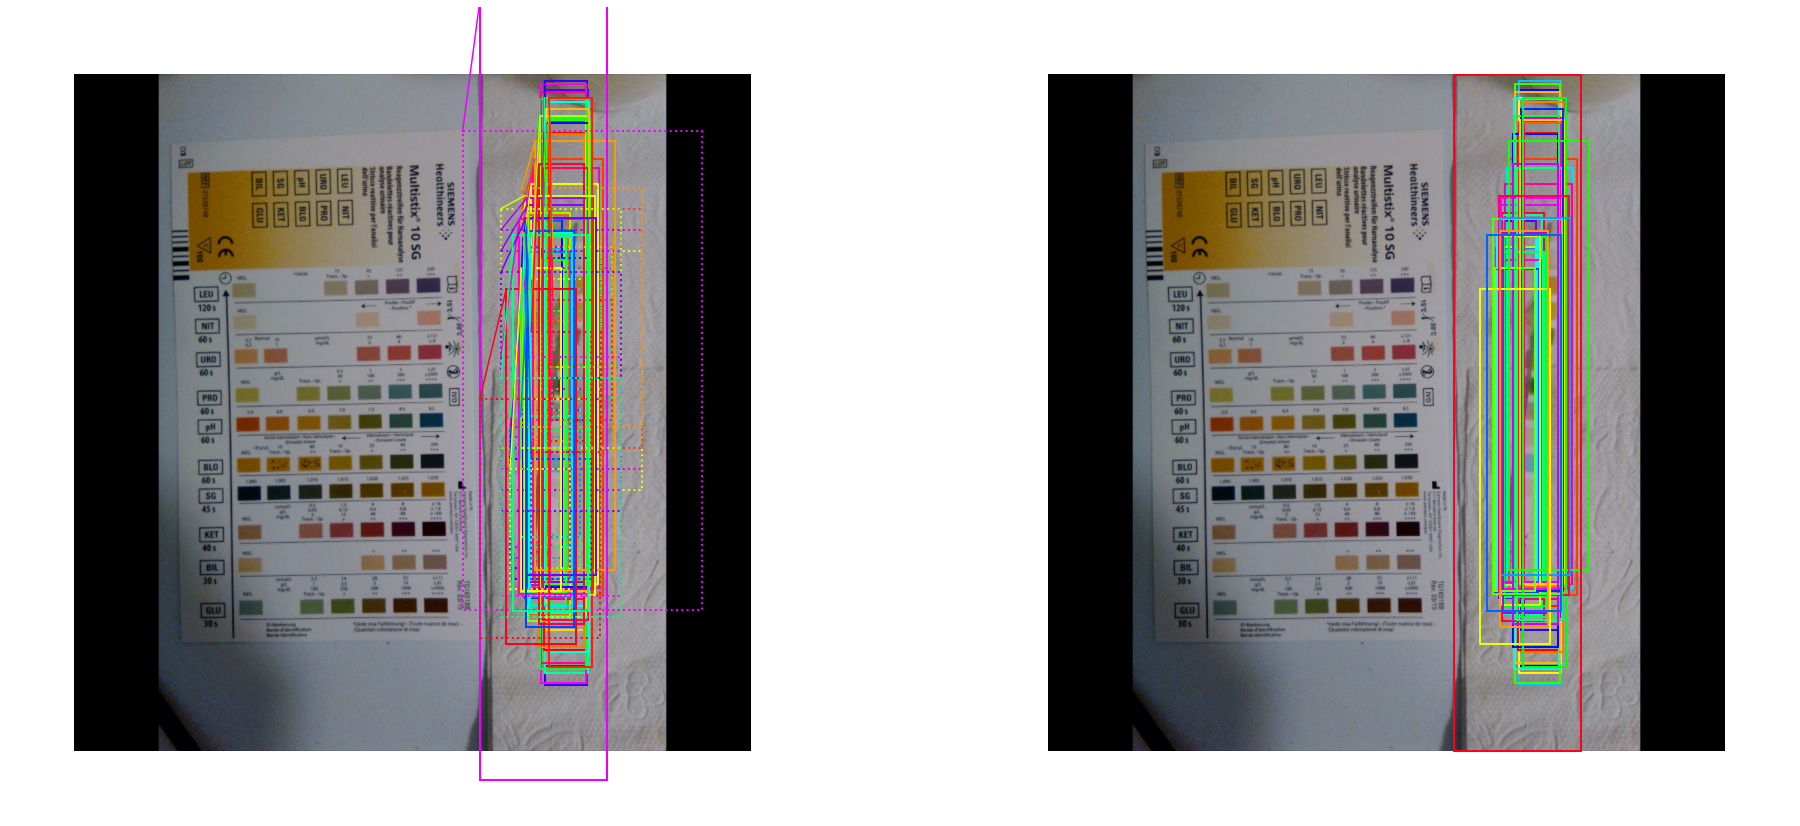

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

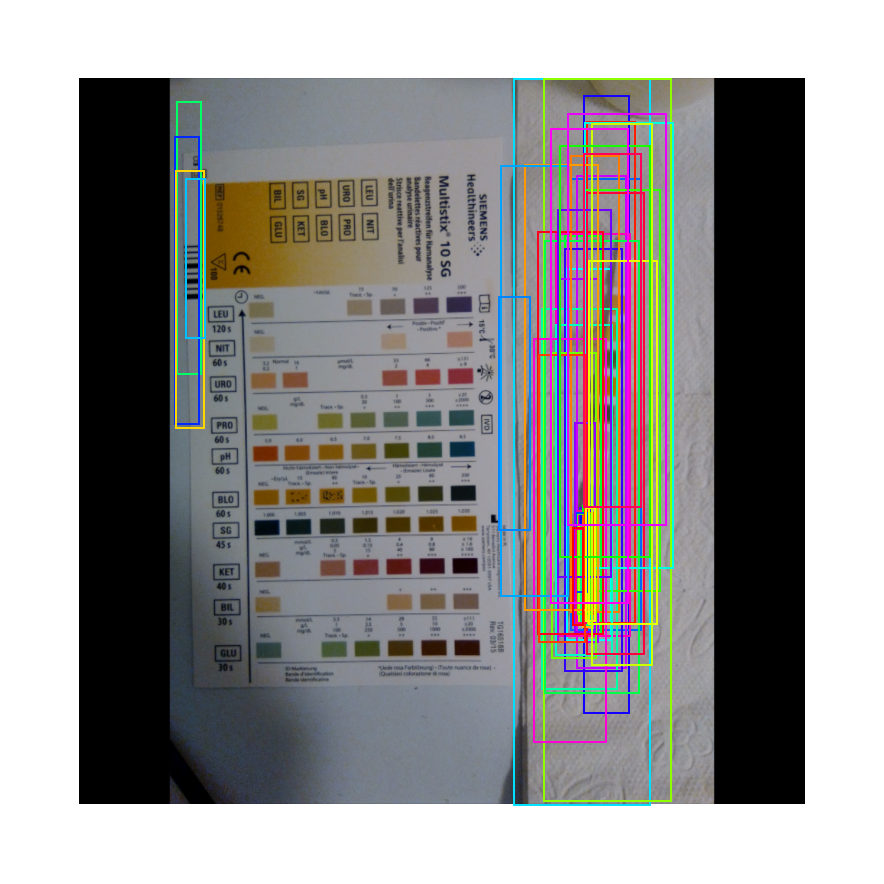

In [ ]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

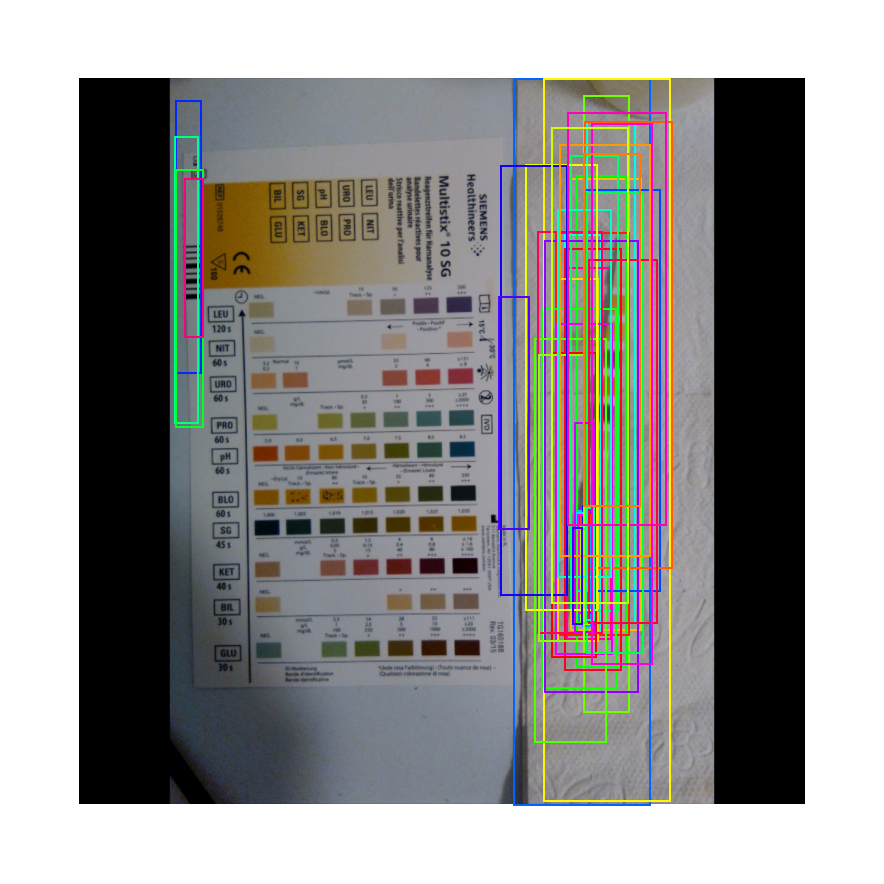

In [ ]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -6.04533  max:    3.98274  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


1 detections: ['stick']


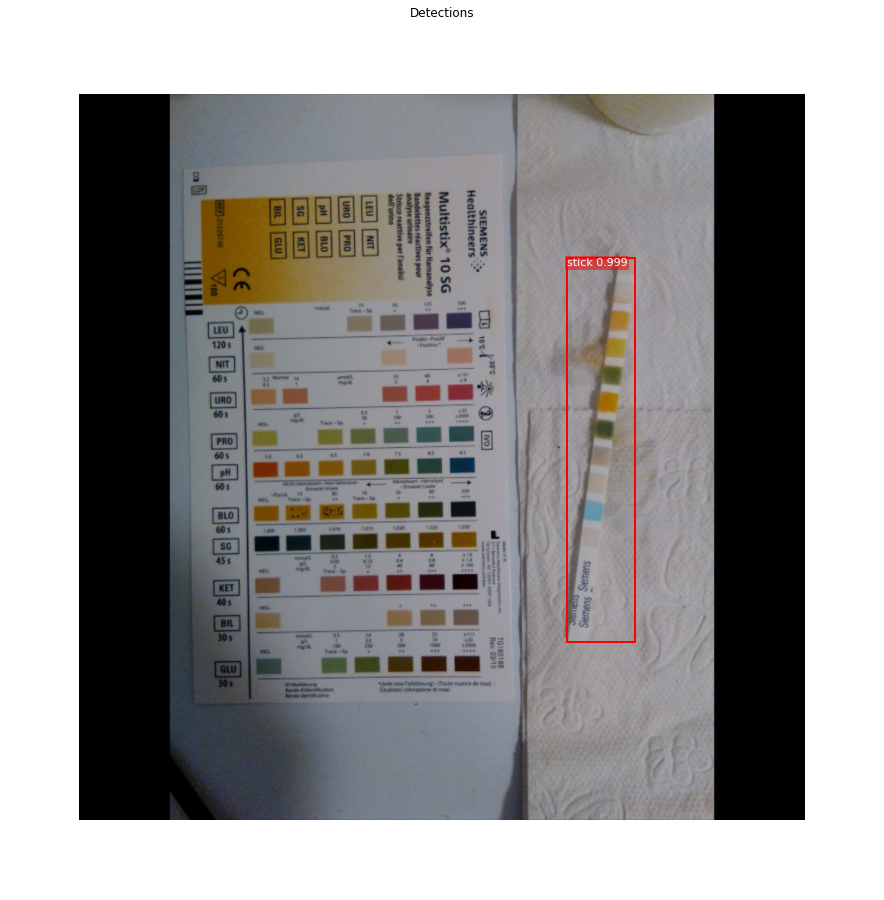

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [ ]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
54 Positive ROIs
[('BG', 946), ('stick', 54)]


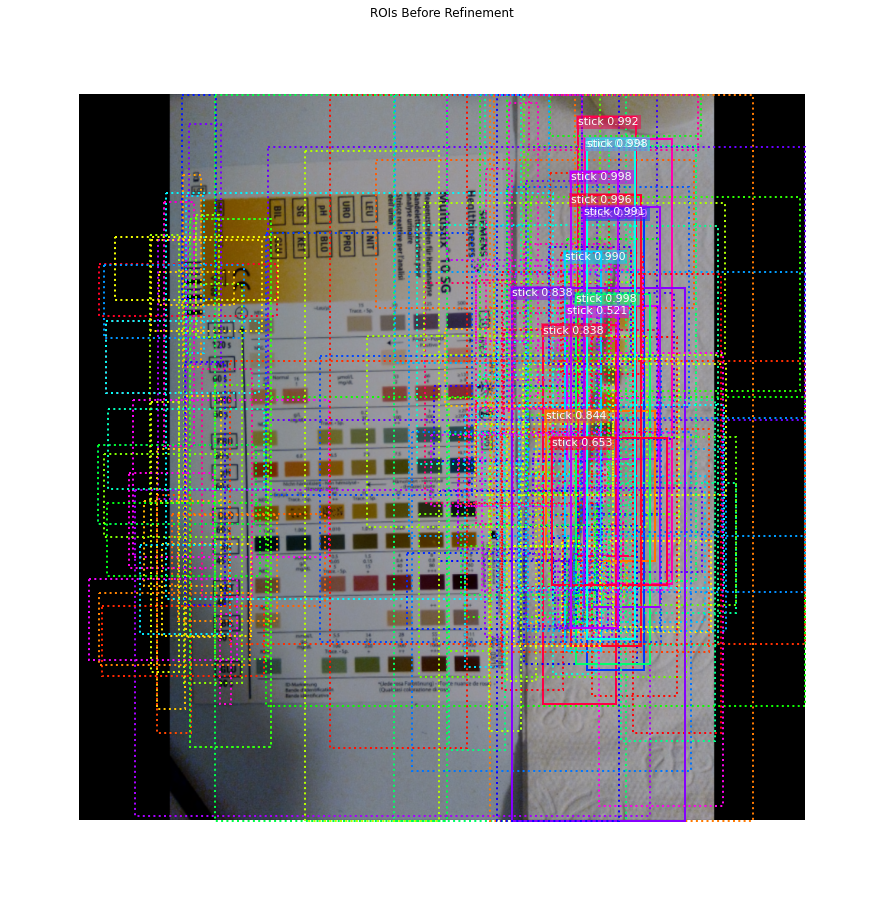

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -4.02370  max:    3.75144
refined_proposals        shape: (1000, 4)             min: -347.00000  max: 1334.00000


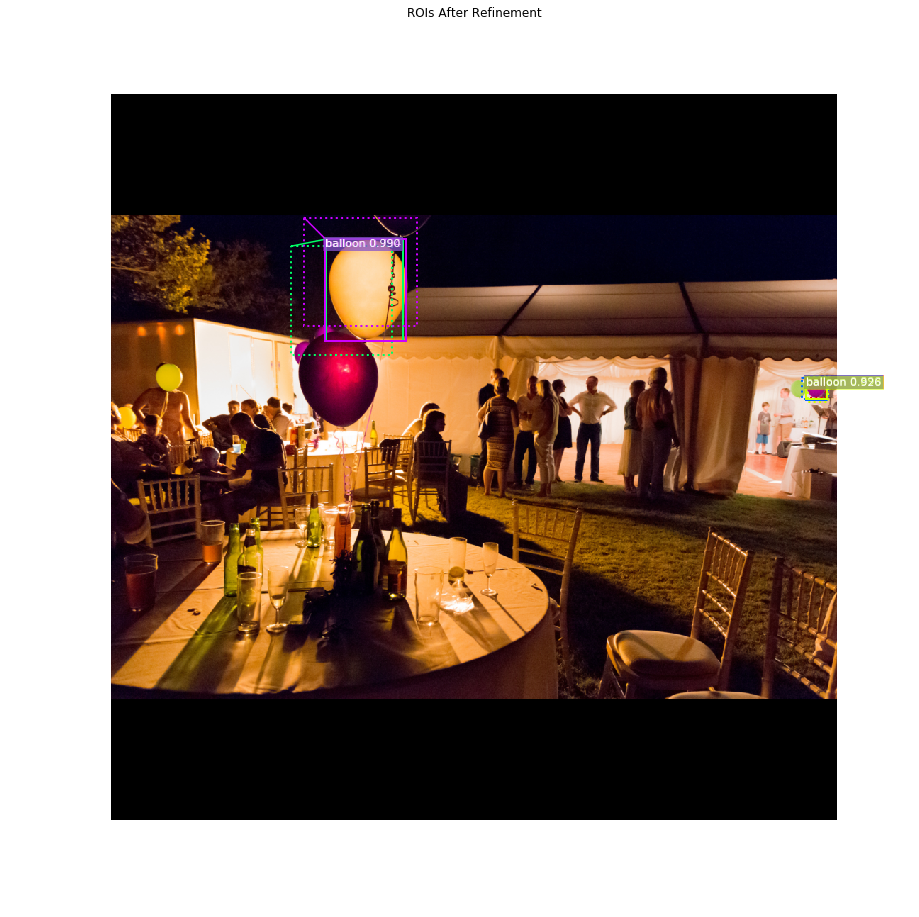

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 24 detections:
[  0   1   4   5   9  10  13  18  21  25  47  62  74  78  87 133 160 162
 176 178 234 317 660 928]


In [ ]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 20:
[  0   1   4   5   9  10  13  21  25  47  62  74  78 160 162 176 178 317
 660 928]


#### Per-Class Non-Max Suppression

In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

balloon               : [  0   1   4   5   9  10  13  21  25  47  62  74  78 160 162 176 178 317
 660 928] -> [1 4 0 5]

Kept after per-class NMS: 4
[0 1 4 5]


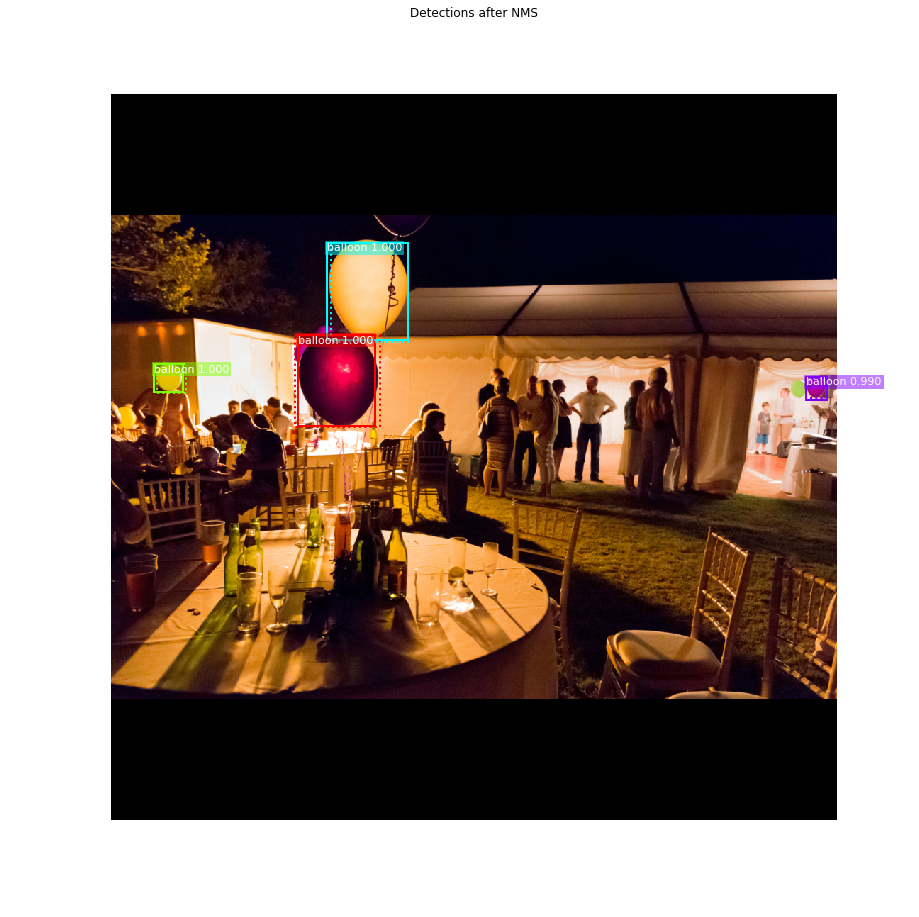

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

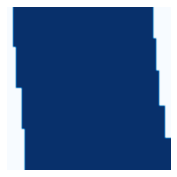

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
1 detections: ['stick']


In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (1, 28, 28)           min:    0.00000  max:    1.00000  float32
det_masks                shape: (1, 1024, 1024)       min:    0.00000  max:    1.00000  bool


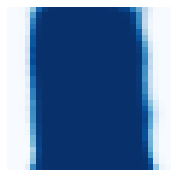

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

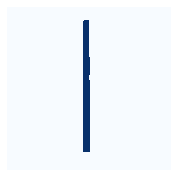

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   22.44727  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   28.80073  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   56.00397  float32
rpn_bbox                 shape: (1, 261888, 4)        min:  -13.95719  max:   44.32391  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


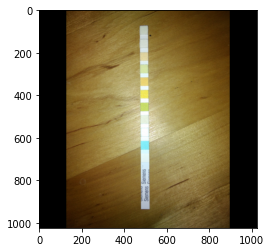

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

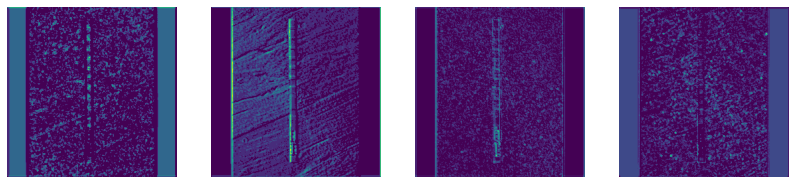

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)